# SUDS Regression
#### Author: Vikram Abbaraju
This notebook covers the data pre-processing, model creation and model evaluation for predicting the change in SUDS scores.

## I. Organize Data

In [4]:
## Parameter initialization (clear all)
from IPython import get_ipython
get_ipython().magic('reset -sf')

import os
import pandas as pd
import scipy.io as sio
import numpy as np
from scipy.signal import butter, filtfilt, resample 
import matplotlib.pyplot as plt
import math 

# Prepare to extract data from .csv files

# Make sure you insert your own path here
main_path = '../'
features_path = main_path + 'Consolidated_Features'

Subject = os.listdir(features_path) # Post_MI: 35, Healthy: 9
# Subject.remove('.DS_Store')
NumSub = np.size(Subject)
subj_list = [
    "3128", "3129", "3130", "3131", "3132", "3133", "3136", "3137", "3138", "3139", 
    "3140", "3141", "3142", "3143", "3147", "3148", "3149", "3150", "3151", "3152", 
    "3154", "3155", "3156", "3158", "3159", "3160", "3162", "6037", "6038", 
    "6043", "6044", "6045", "6046", "6047", "6048", "6049"]
NumStim = 5
Stimulus = ['Rest', 'Reading', 'SpeechPrep', 'Speech', 'Recovery']
NumFeat = 5
Feature = ['HR', 'PAT', 'PEP', 'PPGamp', 'PTTrecip']
Unit = ['bpm', 's', 's', 'au', '1/s']
# 1st column: time, second column: feature values
Subj = np.zeros(len(Subject))
for i in range(len(Subject)):
    Subj[i] = int(Subject[i][3:])  
Subj.sort()

In [5]:
# Extract physio features from .csv files
dataframes_MI = []
dataframes_Ht = []
sub_MI = -1;
sub_Ht = -1;
for sub in range(NumSub):
    if str(round(Subj[sub])) in subj_list:
        if str(Subj[sub]).startswith('3'):
            sub_MI = sub_MI+1;
            dataframes_MI.append([]) 
            for stim in range(NumStim):
                dataframes_MI[sub_MI].append([]) 
                for feat in range(NumFeat):
                    dataframes_MI[sub_MI][stim].append([]) 
                    Feat_load = os.path.join(features_path, 'sub' + str(int(Subj[sub])), 'stim' + str(stim) + '_' + Feature[feat] + '.csv');
                    data = pd.read_csv(Feat_load)
                    dataframes_MI[sub_MI][stim][feat] = data.values
        if str(Subj[sub]).startswith('6'):
            sub_Ht = sub_Ht+1;
            dataframes_Ht.append([])
            for stim in range(NumStim):
                dataframes_Ht[sub_Ht].append([])
                for feat in range(NumFeat):
                    dataframes_Ht[sub_Ht][stim].append([])
                    Feat_load = os.path.join(features_path, 'sub' + str(int(Subj[sub])), 'stim' + str(stim) + '_' + Feature[feat] + '.csv');
                    data = pd.read_csv(Feat_load)
                    dataframes_Ht[sub_Ht][stim][feat] = data.values

In [7]:
# Extract SUDS scores
subj_list = list(map(int, subj_list))
suds = pd.read_csv(main_path + 'suds.csv')
suds = suds[suds.patid.isin(subj_list)]

suds_pre_speech_MI = suds[np.floor(suds.patid.values / 1000) == 3].suds_distress_pre.values
suds_post_speech_MI = suds[np.floor(suds.patid.values / 1000) == 3].suds_distress_post.values

suds_pre_speech_Ht = suds[np.floor(suds.patid.values / 1000) == 6].suds_distress_pre.values
suds_post_speech_Ht = suds[np.floor(suds.patid.values / 1000) == 6].suds_distress_post.values

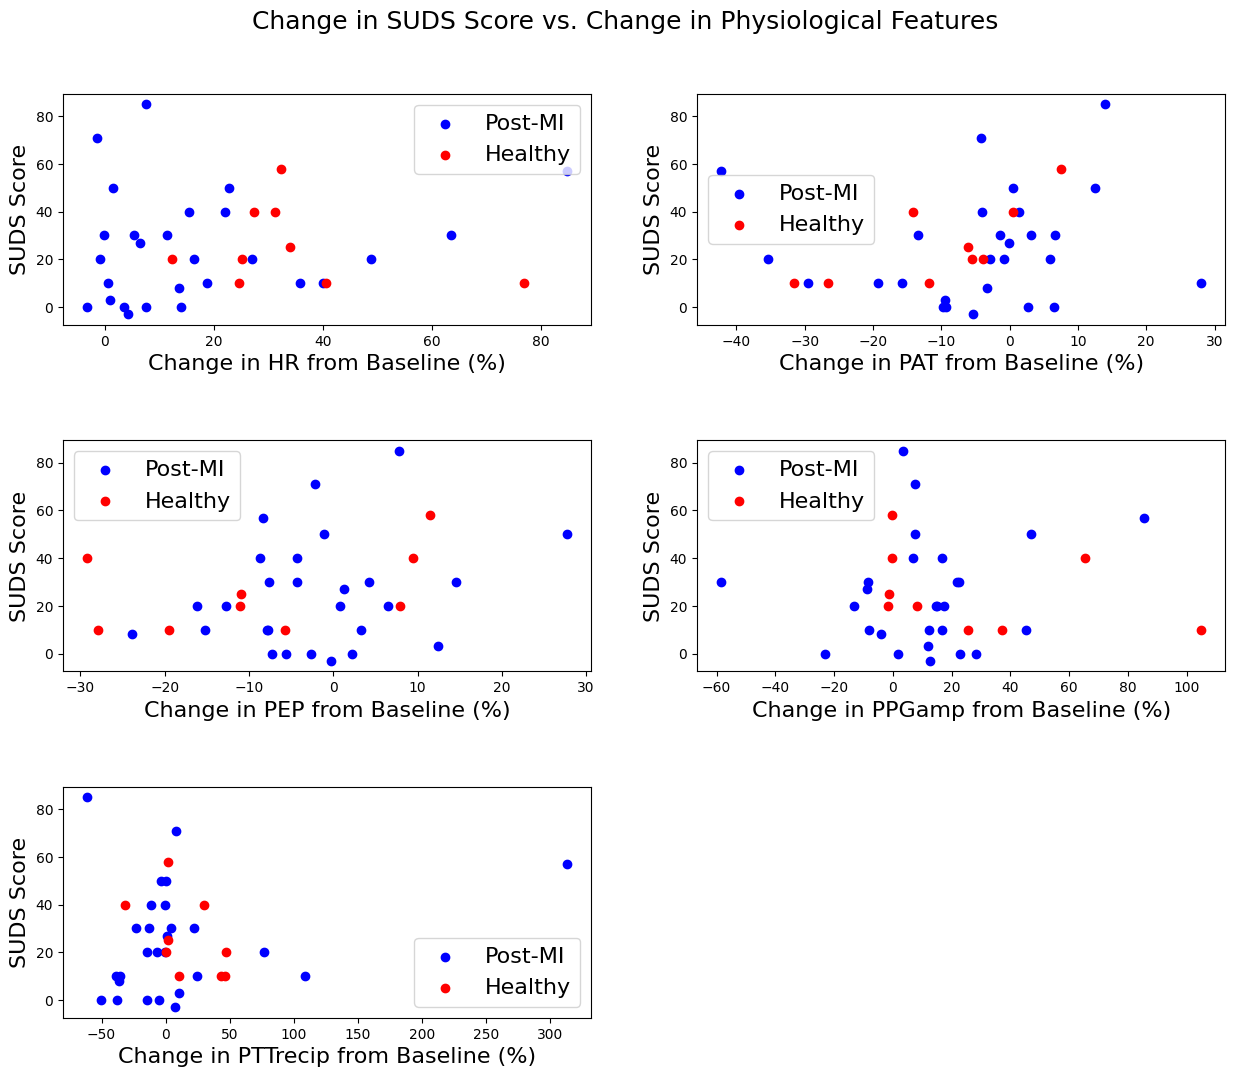

In [8]:
# Isolate features from speech preparation stimulus (stim 2), compute average, and plot against SUDS

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Change in SUDS Score vs. Change in Physiological Features", fontsize=18, y=0.95)

for i in range(NumFeat):

    speech_prep_feature_MI = []
    speech_prep_feature_Ht = []
    
    MI_idx = 0
    Ht_idx = 0
    
    for subj in subj_list:

        if str(subj)[0] == '3':
            baseline = dataframes_MI[MI_idx][0][i][:, 1]
            feature = dataframes_MI[MI_idx][2][i][:, 1]
            speech_prep_feature_MI.append(100*(np.mean(feature) - np.mean(baseline))/np.mean(baseline))
            MI_idx += 1
            
        if str(subj)[0] == '6':
            baseline = dataframes_Ht[Ht_idx][0][i][:, 1]
            feature = dataframes_Ht[Ht_idx][2][i][:, 1]
            speech_prep_feature_Ht.append(100*(np.mean(feature) - np.mean(baseline))/np.mean(baseline))
            Ht_idx += 1
    
    speech_prep_feature_MI = np.asarray(speech_prep_feature_MI)
    speech_prep_feature_Ht = np.asarray(speech_prep_feature_Ht)
    
    ax = plt.subplot(3, 2, i+1)
    ax.scatter(speech_prep_feature_MI, suds_post_speech_MI - suds_pre_speech_MI, color='b')
    ax.scatter(speech_prep_feature_Ht, suds_post_speech_Ht - suds_pre_speech_Ht, color='r')
    ax.set_xlabel('Change in ' + Feature[i] + " from Baseline (%)", fontsize = 16)
    ax.set_ylabel('SUDS Score', fontsize = 16)
    ax.legend(['Post-MI', 'Healthy'], fontsize = 16)

## II. Feature Extraction

In [9]:
# Compute baseline and speech prep features

from sklearn.preprocessing import StandardScaler

baseline_features = []
speechprep_features = []

baseline = 0
speechprep = 2

for subj_no in range(len(subj_list)):
    
    subj_baseline_features = []
    subj_speechprep_features = []
    
    # First, add the "health status" of the subject as a categorical feature
    subj_baseline_features.append(0)
    subj_speechprep_features.append(int(suds.patid.values[subj_no] / 6000))
    
    # Now, loop through the data in "Consolidated_Features" and compute additional simple statistical features
    for feat_no in range(NumFeat):
        
        if subj_no <= 26:
            baseline_signal = dataframes_MI[subj_no][baseline][feat_no][:, 1]
            speechprep_signal = dataframes_MI[subj_no][speechprep][feat_no][:, 1]
        else:
            baseline_signal = dataframes_Ht[subj_no-27][baseline][feat_no][:, 1]
            speechprep_signal = dataframes_Ht[subj_no-27][speechprep][feat_no][:, 1]
        
        # 1) Mean
        subj_baseline_features.append(np.mean(baseline_signal))
        subj_speechprep_features.append(np.mean(speechprep_signal))
        
        #2) Standard Deviation
        subj_baseline_features.append(np.std(baseline_signal))
        subj_speechprep_features.append(np.std(speechprep_signal))
        
        #3) Minimum
        subj_baseline_features.append(np.min(baseline_signal))
        subj_speechprep_features.append(np.min(speechprep_signal))
        
        #4) Maximum
        subj_baseline_features.append(np.max(baseline_signal))
        subj_speechprep_features.append(np.max(speechprep_signal))
        
        #5) Median
        subj_baseline_features.append(np.median(baseline_signal))
        subj_speechprep_features.append(np.median(speechprep_signal))
    
    # Finally, get the HRV features
    
    HRV_feat = pd.read_csv("../HRV/HRV_feat_all/sub" + str(subj_list[subj_no]) + "_HRV_feat.csv")
    
    subj_baseline_features.extend(HRV_feat.iloc[baseline, 1:15].values)
    subj_speechprep_features.extend(HRV_feat.iloc[speechprep, 1:15].values)
    
    baseline_features.append(subj_baseline_features)
    speechprep_features.append(subj_speechprep_features)
    
    
# Normalize all the features by applying the standard scaler after subtracting the baseline values
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(np.asarray(speechprep_features) - np.asarray(baseline_features)))
df[0][df[0].values > 0] = int(1)
df[0][df[0].values < 0] = int(0)
df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,-0.323423,-0.079617,-0.511804,0.179631,-0.255809,0.228567,-0.345384,0.122558,0.460757,...,0.522447,-0.157346,0.635290,-0.143419,-0.018824,0.086828,-0.530355,-1.269654,1.269654,-0.122065
1,0.0,-1.030309,0.086845,-0.487766,-0.293686,-1.065513,0.405188,-1.240016,1.075301,-4.148660,...,0.185965,0.356550,-0.361973,0.298724,-0.018212,-0.069862,0.196498,0.504413,-0.504413,0.286995
2,0.0,0.499766,1.108652,1.045611,0.815706,0.303086,1.388059,1.221618,-0.118056,0.868678,...,0.083366,-0.305828,0.114460,0.000862,-0.071242,-0.070568,0.419705,0.092809,-0.092809,-0.083795
3,0.0,1.534688,2.068848,0.388942,0.883261,1.479928,-0.746117,-0.122584,-0.064994,-0.229912,...,0.676632,1.589268,-0.507140,0.918380,0.035200,0.049934,-0.083941,-0.308566,0.308566,1.095839
4,0.0,-0.520779,0.186297,-0.230054,-0.463600,-0.606595,1.202169,0.675383,3.409764,-1.031947,...,0.905510,0.221929,1.016181,0.193234,-0.134496,-0.956506,0.099203,-0.006556,0.006556,-0.435915
5,0.0,-0.953151,-0.163377,-0.650755,0.152658,-1.075394,-0.208006,-2.687944,0.386503,-0.295799,...,0.382326,0.718578,-0.092840,0.320648,-0.007776,-0.059216,0.505554,0.341908,-0.341908,0.324544
6,0.0,2.822885,0.451650,2.670257,1.599191,2.679318,-2.276102,-2.026496,-1.100033,-1.719141,...,-1.047213,0.086997,-2.384277,0.271368,-0.067775,-0.142681,1.392658,1.908211,-1.908211,0.182609
7,0.0,1.936021,0.521878,1.991295,1.766945,1.826378,-2.208532,-1.519837,3.037518,-0.798313,...,-0.735878,0.325043,-1.670752,0.328165,-0.119749,-0.144152,0.293794,0.347859,-0.347859,0.215495
8,0.0,0.101327,-0.071996,-1.082300,-0.107087,0.457032,0.272462,0.281737,-0.622448,0.408505,...,3.255398,-2.182424,2.377814,-4.817192,5.240359,5.528053,0.190775,0.439818,-0.439818,0.958169
9,0.0,-1.141998,0.191240,-0.837132,-0.165958,-1.203260,0.051466,2.179038,-0.611003,0.527458,...,0.361523,0.289485,1.349412,0.287410,-0.018681,-0.059930,0.019078,-0.316638,0.316638,0.279825


## III. Model Training/Testing

In [108]:
from sklearn import linear_model, kernel_ridge, svm, decomposition
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import mean_squared_error, r2_score


# Prepare X (features) and y (change in SUDS scores)
X = df.to_numpy()
y = np.concatenate((suds_post_speech_MI - suds_pre_speech_MI, suds_post_speech_Ht - suds_pre_speech_Ht))

# Split the data into training/test (70/30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

def root_mean_squared_error(y_train, y_pred):
    return math.sqrt(mean_squared_error(y_train, y_pred))

# Define a function to return the leave-one-out validation RMSE
loo = LeaveOneOut()
def leave_one_out_val(loo, X_train, y_train, regr):
    y_val_pred = np.zeros((np.shape(y_train)))
    for j, (train_indices, val_index) in enumerate(loo.split(X_train)):
        regr.fit(X_train[train_indices, :], y_train[train_indices])
        y_val_pred[j] = regr.predict(X_train[val_index])
    return root_mean_squared_error(y_train, y_val_pred)

# Create lists to keep track of accuracy (RMSE)
train_acc = []
cv_acc = []
test_acc = []

models = []
model_names = []
model_coef = []
y_pred = []

### Model 1: Least Squares Regression

In [109]:
regr1 = linear_model.LinearRegression()

# Fit training data
regr1.fit(X_train, y_train);

y_train_pred = regr1.predict(X_train)
y_test_pred = regr1.predict(X_test)
y_pred.append(y_test_pred)

train_acc.append(root_mean_squared_error(y_train, y_train_pred))
cv_acc.append(0)
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

models.append(regr1)
model_names.append("Least Squares")
model_coef.append(regr1.coef_)

### Model 2: Ridge Regression

In [110]:
regr2_temp = [] # list to store different models for hyperparam tuning
cv_acc_temp = [] # list to store the RMSE on the validation set for each model

# Tune alpha using leave-one-out cross validation
for i, alpha in enumerate([1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]): 
    regr = linear_model.Ridge(alpha=alpha) # define the model
    cv_acc_temp.append(leave_one_out_val(loo, X_train, y_train, regr)) # perform leave-one-out CV
    regr2_temp.append(regr)

# Choose the model with the best CV accuracy
regr2 = regr2_temp[np.argmin(cv_acc_temp)]
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
regr2.fit(X_train, y_train) 
y_train_pred = regr2.predict(X_train)
y_test_pred = regr2.predict(X_test)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr2)
model_names.append("Ridge")
model_coef.append(regr2.coef_)
print(np.argmin(cv_acc_temp))

5


### Model 3: LASSO

In [111]:
regr3_temp = [] 
cv_acc_temp = []

# Tune alpha using leave-one-out cross validation
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]):
    regr = linear_model.Lasso(alpha=alpha)
    cv_acc_temp.append(leave_one_out_val(loo, X_train, y_train, regr))
    regr3_temp.append(regr)
    
# Choose the model with the best CV accuracy 
regr3 = regr3_temp[np.argmin(cv_acc_temp)]
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
y_train_pred = regr3.predict(X_train)
y_test_pred = regr3.predict(X_test)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr3)
model_names.append("LASSO")
model_coef.append(regr3.coef_)
print(np.argmin(cv_acc_temp))

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.242e+00, tolerance: 1.227e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.211e+01, tolerance: 1.159e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.746e+00, toleranc

5


### Model 4: Elastic-Net

In [112]:
regr4_temp = []
cv_acc_temp = []

l1_ratio = 0.95

# Tune alpha using leave-one-out cross validation
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]):
    regr = linear_model.ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    cv_acc_temp.append(leave_one_out_val(loo, X_train, y_train, regr))
    regr4_temp.append(regr)
    
# Choose the model with the best CV accuracy
regr4 = regr4_temp[np.argmin(cv_acc_temp)]
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
regr4.fit(X_train, y_train)
y_train_pred = regr4.predict(X_train)
y_test_pred = regr4.predict(X_test)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr4)
model_names.append("Elastic-Net")
model_coef.append(regr4.coef_)
print(np.argmin(cv_acc_temp))

5


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.743e+01, tolerance: 1.227e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.998e+01, tolerance: 1.159e+00
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.197e+00, toleranc

### Model 5: (RBF) Kernel Ridge Regression

In [113]:
regr5_temp = []
cv_acc_temp = [] # list to store the MSE on the validation set for each model

g = 0.000001

# Tune alpha using leave-one-out-cross validation
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]):
    regr = kernel_ridge.KernelRidge(alpha=alpha, kernel='rbf', gamma=g)
    print(leave_one_out_val(loo, X_train, y_train, regr))
    cv_acc_temp.append(leave_one_out_val(loo, X_train, y_train, regr))
    regr5_temp.append(regr)

# Choose the model with the best CV accuracy
regr5 = regr5_temp[np.argmin(cv_acc_temp)]
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
regr5.fit(X_train, y_train)
y_train_pred = regr5.predict(X_train)
y_test_pred = regr5.predict(X_test)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr5)
model_names.append("KRR")
model_coef.append(regr5.dual_coef_)
print(np.argmin(cv_acc_temp))

23.834449298711917
23.189857978776367
23.117887222673524
23.101443041510713
24.11059077557304
30.791813046585382
33.91088795431983
3


### Model 6: Support Vector Regression (RBF Kernel)

In [114]:
regr6_temp = []
cv_acc_temp = []

g = 100
epsilon = 20

# Tune C using leave-one-out cross validation
for i, C in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]):
    regr = svm.SVR(kernel='rbf', gamma=g, C=C, epsilon=epsilon)
    cv_acc_temp.append(leave_one_out_val(loo, X_train, y_train, regr))
    regr6_temp.append(regr)
    
# Choose the model with the best CV accuracy
regr6 = regr6_temp[np.argmin(cv_acc_temp)] # chose the model that performed best on the validation set
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
regr6.fit(X_train, y_train)
y_train_pred = regr6.predict(X_train)
y_test_pred = regr6.predict(X_test)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr6)
model_names.append("SVR")
model_coef.append(regr6.dual_coef_)
print(np.argmin(cv_acc_temp))

4


### Model 7: PCA + Ridge Regression

In [115]:
regr7_temp = []
cv_acc_temp = []

# Perform PCA
k = 3
xPCA = decomposition.PCA(n_components=k)
xPCA.fit(X_train)
X_train_pc = xPCA.transform(X_train)
X_test_pc = xPCA.transform(X_test)

# Tune alpha using leave-one-out cross-validation
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 1e4, 1e5]): # loop through different values for alpha
    regr = linear_model.Ridge(alpha=alpha)
    cv_acc_temp.append(leave_one_out_val(loo, X_train_pc, y_train, regr))
    regr7_temp.append(regr)
    
# Choose the model with the best CV accuracy
regr7 = regr7_temp[np.argmin(cv_acc_temp)]
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
regr7.fit(X_train_pc, y_train)
y_train_pred = regr7.predict(X_train_pc)
y_test_pred = regr7.predict(X_test_pc)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr7)
model_names.append("PCA + Ridge")
model_coef.append(regr7.coef_)
print(np.argmin(cv_acc_temp))

8


## Model 8: PCA + LASSO

In [116]:
regr8_temp = []
cv_acc_temp = []

# Perform PCA
k = 3
xPCA = decomposition.PCA(n_components=k)
xPCA.fit(X_train)
X_train_pc = xPCA.transform(X_train)
X_test_pc = xPCA.transform(X_test)

# Tune alpha using leave-one-out cross-validation
for i, alpha in enumerate([0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]): # loop through different values for alpha
    regr = linear_model.Lasso(alpha=alpha)
    cv_acc_temp.append(leave_one_out_val(loo, X_train_pc, y_train, regr))
    regr8_temp.append(regr)
    
# Choose the model with the best CV accuracy
regr8 = regr8_temp[np.argmin(cv_acc_temp)]
cv_acc.append(np.min(cv_acc_temp))

# Re-train the model with all training samples and obtain training and test accuracy
regr8.fit(X_train_pc, y_train)
y_train_pred = regr8.predict(X_train_pc)
y_test_pred = regr8.predict(X_test_pc)
y_pred.append(y_test_pred)
train_acc.append(root_mean_squared_error(y_train, y_train_pred))
test_acc.append(root_mean_squared_error(y_test, y_test_pred))

# Store the models for visualization later
models.append(regr8)
model_names.append("PCA + LASSO")
model_coef.append(regr8.coef_)
print(np.argmin(cv_acc_temp))

5


## IV. Results

[183.2564420075189, 18.113304461788328, 18.080400544191043, 18.114066859262117, 17.920356323865626, 18.669123656658517, 18.115581428865667, 18.114066859262117]


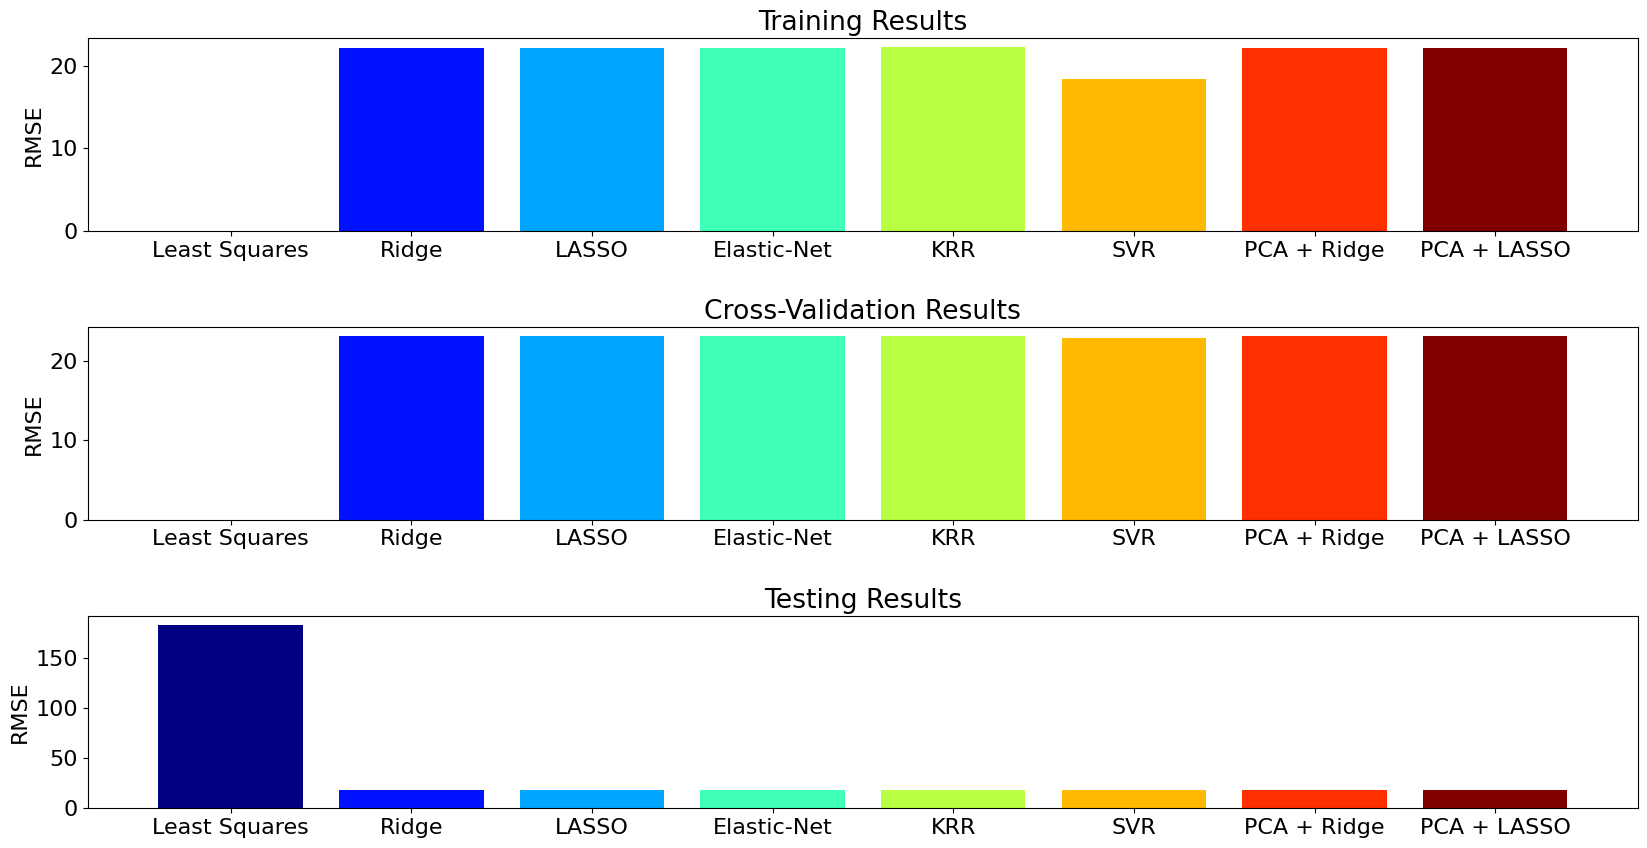

In [117]:
# Visualize the results
plt.rcParams.update({'font.size': 16})

n = len(models)
model_colors = plt.cm.jet(np.linspace(0,1,n))

fig, axs = plt.subplots(3, 1, figsize=(20, 10))
plt.subplots_adjust(hspace=0.5)
axs[0].bar(model_names, train_acc, color=model_colors)
# axs[0].set_ylim([0.52, 0.53])
axs[0].set_ylabel('RMSE')
axs[0].set_title('Training Results')

axs[1].bar(model_names, cv_acc, color=model_colors)
# axs[1].set_ylim([0.52, 0.525])
axs[1].set_ylabel('RMSE')
axs[1].set_title('Cross-Validation Results')

axs[2].bar(model_names, test_acc, color=model_colors)
# axs[2].set_ylim([0.525, 0.535])
axs[2].set_ylabel('RMSE')
axs[2].set_title('Testing Results')

print(test_acc)

40
40
40
40
25
10
3
3


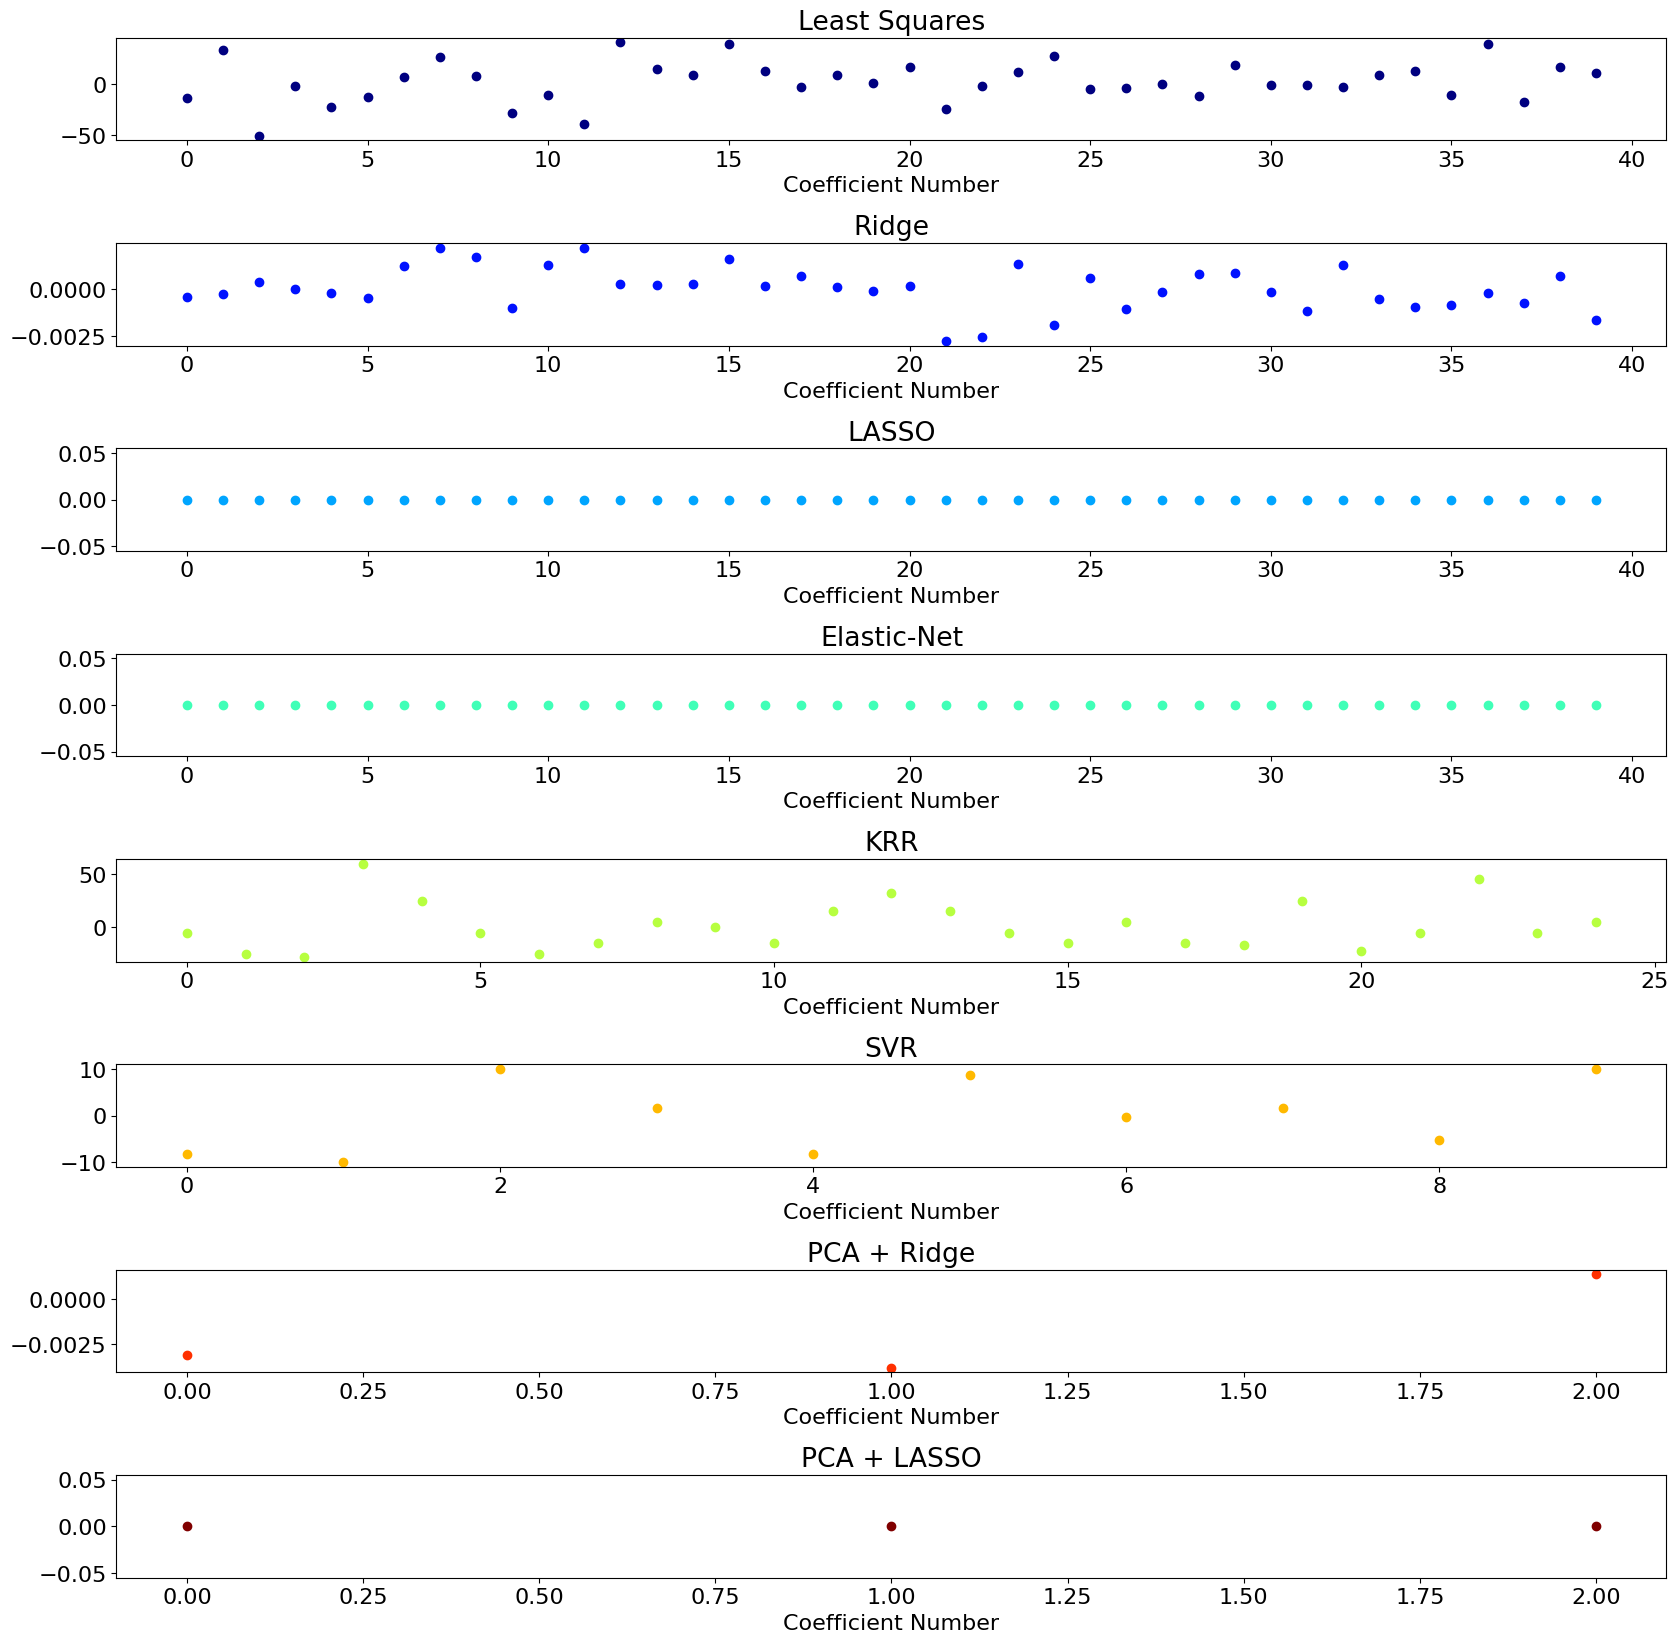

In [118]:
# Visualize the model coefficients
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=1.0)
n = len(models)
for i in range(n):
    ax = plt.subplot(n, 1, i+1)
    x = np.arange(0, len(model_coef[i].flatten()))
    print(len(model_coef[i].flatten()))
    ax.scatter(x, model_coef[i].flatten(), color=model_colors[i])
    ax.set_xlabel('Coefficient Number')
    ax.set_title(model_names[i])

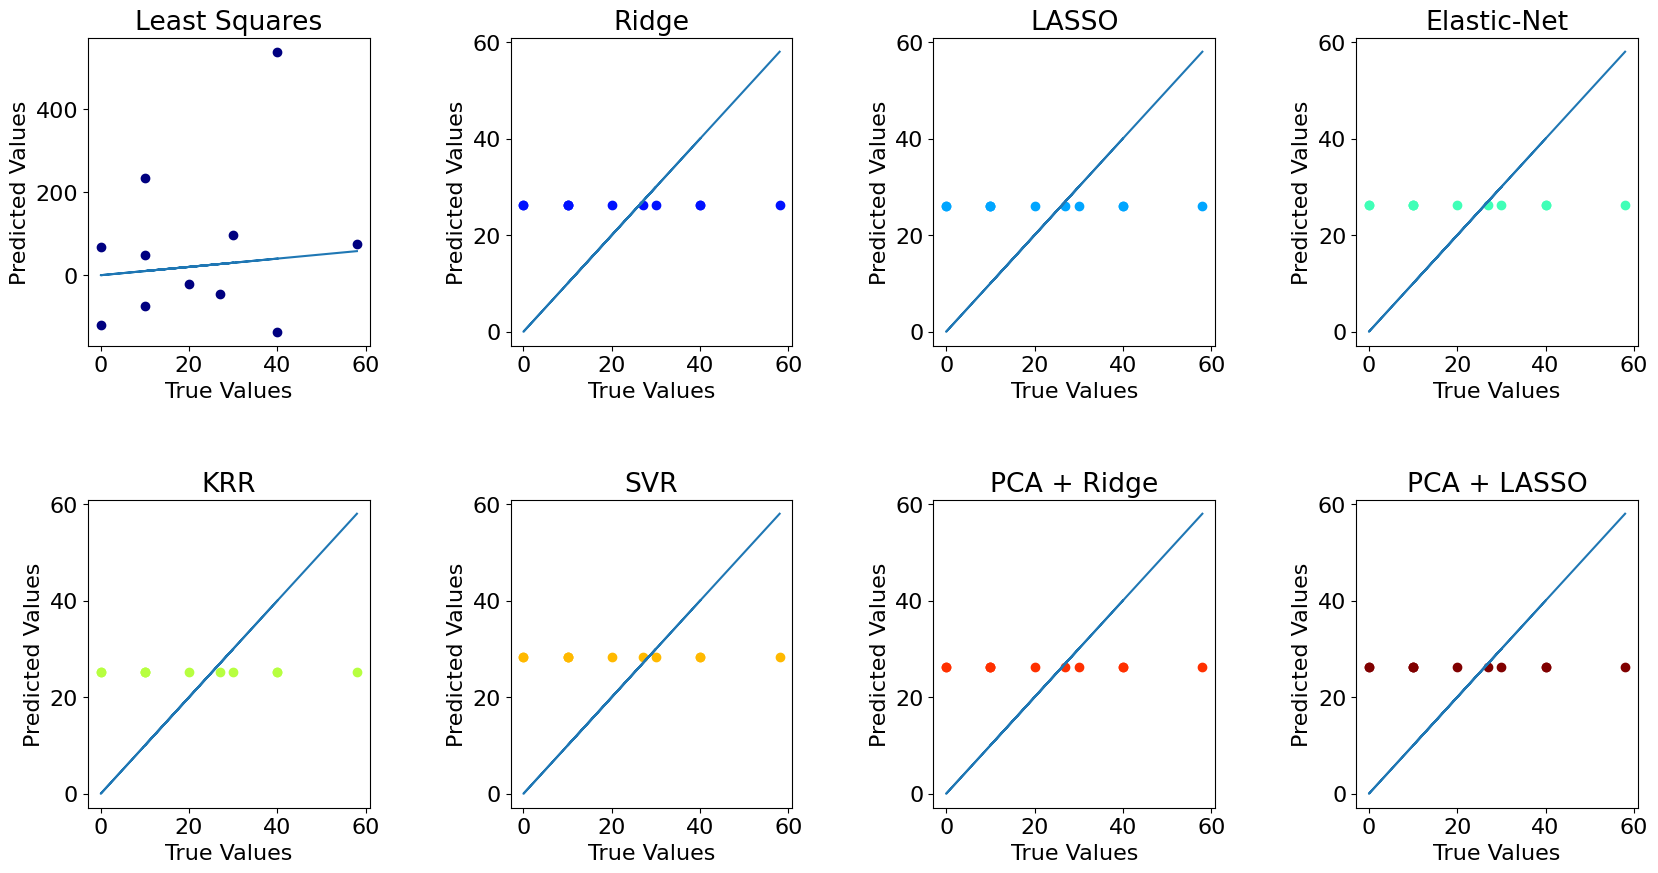

In [126]:
# Visualize the predictions from each model compared to ground truth
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
n = len(models)
for i in range(n):
    ax = plt.subplot(2, 4, i+1)
    ax.scatter(y_test, y_pred[i], color=model_colors[i])
    ax.plot(y_test, y_test)
    ax.set_xlabel('True Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(model_names[i])